# Movie Sentiment Analysis

In [246]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, Conv1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

### Dataset

In [208]:
movie_reviews_train = pd.read_csv("data/train.csv")
movie_reviews_test = pd.read_csv("data/test.csv")
movie_reviews_train.isnull().values.any()
movie_reviews_test.isnull().values.any()
movie_reviews_train.shape, movie_reviews_test.shape

((20000, 9), (2000, 9))

In [211]:
movie_reviews_train.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,4wjJe3AxFyVOSMHLRh68Og,8,2009-08-22 21:06:56,10,ygjO-o4_YoXr41D7Rx9vmw,4,"""What do you do for recreation?""\n\n""Oh, the u...",9,K0sapHOlhlGNjx3GBeSf5A


In [212]:
def pos(row):
    if row['stars'] == 3 or row['stars'] == 4 or row['stars'] == 5:
        val = 1
    elif row['stars'] == 0 or row['stars'] == 1 or row['stars'] == 2 :
        val = 0
    return val

In [213]:
movie_reviews_train['pos'] = movie_reviews_train.apply(pos, axis=1)
movie_reviews_test['pos'] = movie_reviews_test.apply(pos, axis=1)

In [214]:
movie_reviews_train.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,pos
0,4wjJe3AxFyVOSMHLRh68Og,8,2009-08-22 21:06:56,10,ygjO-o4_YoXr41D7Rx9vmw,4,"""What do you do for recreation?""\n\n""Oh, the u...",9,K0sapHOlhlGNjx3GBeSf5A,1
1,xGXzIliuZ6FgMS870UjPRw,0,2017-08-24 16:53:53,0,MN5bVycm01xc7V3PPBPoMQ,5,The burgers are good and they have good fries ...,0,ykiNDnGo_66TsjknglEcjQ,1
2,wdwODzBChLIh_u8V8CPpyA,0,2014-08-15 02:31:54,0,9eDWY5cevgRhywg6uTm8Pw,2,"Been there three times, twice they didn't have...",0,4y3C9Mml09FzFk6rq6_g2Q,0
3,n8Zqqhff-2cxzWt_nwhU2Q,1,2015-06-30 03:48:18,1,Zt9Yj5K1Y-MnDmocXI9Zgw,5,Pretty excited to discover this Cali gastropub...,1,PH7HEuAqSQgOGDi7Ygnulg,1
4,Em2ZuYiyTr4_ITSCTi86CQ,0,2018-05-25 22:29:25,0,qPR0JlNSMChgCjxY3yyiEw,5,I have been very pleased with the care that I ...,0,5uKGIkrQRISzQCSA6DXtow,1


In [215]:
movie_reviews_train=movie_reviews_train[['text','pos']]
movie_reviews_test=movie_reviews_test[['text','pos']]

In [216]:
movie_reviews_train.head()

,text,pos
0,"""What do you do for recreation?""\n\n""Oh, the u...",1
1,The burgers are good and they have good fries ...,1
2,"Been there three times, twice they didn't have...",0
3,Pretty excited to discover this Cali gastropub...,1
4,I have been very pleased with the care that I ...,1


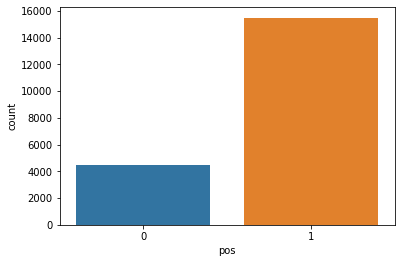

In [201]:
import seaborn as sns
sns.countplot(x='pos', data=movie_reviews)

## Part 1. Data Preprocessing

In [217]:
def preprocess_text(sen):
    # Removing html tags
    # sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [221]:
X_train = []
sentences_train = list(movie_reviews_train['text'])
for sen in sentences_train:
    X_train.append(preprocess_text(sen))

In [222]:
X_test = []
sentences_test = list(movie_reviews_test['text'])
for sen in sentences_test:
    X_test.append(preprocess_text(sen))

In [227]:
Y_train=movie_reviews_train['pos']
Y_test=movie_reviews_test['pos']

### Embedding Layer

In [230]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [232]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [233]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [234]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Part 2. Classification with Simple Neural Network

In [235]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [236]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          3674800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 20001     
Total params: 3,694,801
Trainable params: 20,001
Non-trainable params: 3,674,800
_________________________________________________________________
None


In [238]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=6, verbose=1)

Epoch 1/6
20000/20000 [==============================] - 2s 109us/step - loss: 0.4405 - acc: 0.8023
Epoch 2/6
20000/20000 [==============================] - 1s 28us/step - loss: 0.3038 - acc: 0.8711
Epoch 3/6
20000/20000 [==============================] - 1s 32us/step - loss: 0.2491 - acc: 0.8978
Epoch 4/6
20000/20000 [==============================] - 1s 27us/step - loss: 0.2133 - acc: 0.9193
Epoch 5/6
20000/20000 [==============================] - 1s 27us/step - loss: 0.1875 - acc: 0.9329
Epoch 6/6
20000/20000 [==============================] - 1s 27us/step - loss: 0.1677 - acc: 0.9444


In [239]:
score = model.evaluate(X_test, Y_test, verbose=1)

2000/2000 [==============================] - 0s 125us/step


In [240]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4195699908733368
Test Accuracy: 0.8314999938011169


## Part 3. Classification with Convolutional Neural Network

In [247]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [248]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          3674800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 3,739,057
Trainable params: 64,257
Non-trainable params: 3,674,800
_________________________________________________________________
None


In [260]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=6, verbose=1)

score = model.evaluate(X_test, Y_test, verbose=1)

Epoch 1/6
20000/20000 [==============================] - 85s 4ms/step - loss: 0.2425 - acc: 0.8972
Epoch 2/6
20000/20000 [==============================] - 86s 4ms/step - loss: 0.2335 - acc: 0.9007
Epoch 3/6
20000/20000 [==============================] - 96s 5ms/step - loss: 0.2284 - acc: 0.9043
Epoch 4/6
20000/20000 [==============================] - 83s 4ms/step - loss: 0.2188 - acc: 0.9089
Epoch 5/6
20000/20000 [==============================] - 76s 4ms/step - loss: 0.2143 - acc: 0.9115
Epoch 6/6
2000/2000 [==============================] - 4s 2ms/step


In [261]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2224456981420517
Test Accuracy: 0.9054999947547913


## Part 4. Classification with Recurrent Neural Network (LSTM)

In [256]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [257]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          3674800   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,792,177
Trainable params: 117,377
Non-trainable params: 3,674,800
_________________________________________________________________
None


In [258]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=6, verbose=1)

score = model.evaluate(X_test, Y_test, verbose=1)

Epoch 1/6
20000/20000 [==============================] - 84s 4ms/step - loss: 0.5351 - acc: 0.7707
Epoch 2/6
20000/20000 [==============================] - 92s 5ms/step - loss: 0.5285 - acc: 0.7735
Epoch 3/6
20000/20000 [==============================] - 81s 4ms/step - loss: 0.5139 - acc: 0.7794
Epoch 4/6
20000/20000 [==============================] - 85s 4ms/step - loss: 0.4117 - acc: 0.8188
Epoch 5/6
20000/20000 [==============================] - 74s 4ms/step - loss: 0.2795 - acc: 0.8845
Epoch 6/6
2000/2000 [==============================] - 3s 1ms/step


In [259]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2600295501947403
Test Accuracy: 0.8830000162124634
